<a href="https://colab.research.google.com/github/VishakBharadwaj94/Image_Similarity_AutoEncoder/blob/main/Image_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
data_path
! unzip -q /content/drive/MyDrive/dataset.zip -d /content

In [5]:
import torch
from PIL import Image
import os
import torchvision.transforms as T
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim


In [6]:
from pathlib import Path

path = Path('/content')
data = path/'dataset'

In [7]:
list(data.glob('**/*.jpg'))[:10]

[PosixPath('/content/dataset/2338.jpg'),
 PosixPath('/content/dataset/3717.jpg'),
 PosixPath('/content/dataset/1829.jpg'),
 PosixPath('/content/dataset/1973.jpg'),
 PosixPath('/content/dataset/3679.jpg'),
 PosixPath('/content/dataset/1954.jpg'),
 PosixPath('/content/dataset/630.jpg'),
 PosixPath('/content/dataset/4241.jpg'),
 PosixPath('/content/dataset/3993.jpg'),
 PosixPath('/content/dataset/3128.jpg')]

In [8]:
class Dataset:
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.data_path))

    def __getitem__(self, idx):
        img_loc = self.data_path/f'{idx}.jpg'
        image = Image.open(img_loc).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image,image

In [9]:
#create dataset and print to see if it works, tranforms later

dataset = Dataset(data)

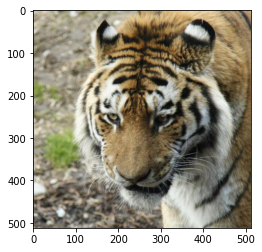

In [10]:
from matplotlib.pyplot import imshow
import numpy as np
%matplotlib inline

def see_data(idx):
  img1,_ = dataset[idx]
  imshow(img1)

see_data(0)

In [11]:
[train_size,val_size] =(len(dataset)-738),738
train_size,val_size

(4000, 738)

In [12]:
class toTensor:

  def __call__(self,image):
    image = np.array(image)
    image = image.transpose((2, 0, 1))
    return (torch.from_numpy(image)).float()

In [13]:
tfms = T.Compose(
    [
     T.Resize((512,512)),
     T.RandomHorizontalFlip(),
     toTensor(),
    ]
) 

In [16]:
dataset = Dataset(data,tfms)

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size]) 

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32)
 
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

In [17]:
xb,yb = next(iter(train_loader))

In [18]:
xb.shape

torch.Size([32, 3, 512, 512])

In [19]:
class ConvEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, (3, 3), padding=(1, 1))
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d((2, 2))

        self.conv2 = nn.Conv2d(16, 32, (3, 3), padding=(1, 1))
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d((2, 2))

        self.conv3 = nn.Conv2d(32, 64, (3, 3), padding=(1, 1))
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d((2, 2))

        # size of the embedding

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        return x

class ConvDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.deconv1 = nn.ConvTranspose2d(64, 32, (2, 2), stride=(2, 2))
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()

        self.deconv2 = nn.ConvTranspose2d(32, 16, (2, 2), stride=(2, 2))
        self.bn2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()

        self.deconv3 = nn.ConvTranspose2d(16, 3, (2, 2), stride=(2, 2))
        self.bn3 = nn.BatchNorm2d(3)
        self.relu3 = nn.ReLU()
  

    def forward(self, x):

        x = self.deconv1(x)
        x = self.bn1(x)
        x = self.relu1(x)


        x = self.deconv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.deconv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        
        return x

In [20]:
enc = ConvEncoder()
out1= enc(dataset[0][0].unsqueeze(0).float())
out1.shape

torch.Size([1, 64, 64, 64])

In [59]:
dec = ConvDecoder()
out2= dec(out1)
out2.shape

torch.Size([1, 3, 512, 512])

In [18]:
criterion = nn.MSELoss()
autoencoder_params = list(enc.parameters()) + list(dec.parameters())
max_lr = 1e-3
optimizer = optim.Adam(autoencoder_params, lr=max_lr)

In [19]:
def train_step(encoder, decoder, train_loader, loss_fn, optimizer,max_lr,epochs):

    encoder.train()
    decoder.train()

    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))

    for batch_idx, (train_img, target_img) in enumerate(train_loader):
        train_img = train_img.cuda()
        target_img = target_img.cuda()

        optimizer.zero_grad()

        enc_output = encoder(train_img)
        dec_output = decoder(enc_output)

        loss = loss_fn(dec_output, target_img)
        loss.backward()
        optimizer.step()
        sched.step()
    return loss.item()


def val_step(encoder, decoder, val_loader, loss_fn):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
      
        for batch_idx, (train_img, target_img) in enumerate(val_loader):
            train_img = train_img.cuda()
            target_img = target_img.cuda()

            enc_output = encoder(train_img)
            dec_output = decoder(enc_output)
            loss = loss_fn(dec_output, target_img)
            
          

    return loss.item()

In [ ]:
#pop the model on GPU and train for around 

enc.cuda()
dec.cuda()

epochs = 2
for epoch in tqdm(range(epochs)):


    train_loss = train_step(enc, dec, train_loader, criterion, optimizer,max_lr,epochs)
    val_loss = val_step(enc, dec, val_loader, criterion)

    print(f"Epochs = {epoch}, Training Loss : {train_loss:.2f} ,Validation Loss : {val_loss:.2f}")

    torch.save(enc.state_dict(), enc_models/f'{epoch}_ft.pt')
    torch.save(dec.state_dict(), dec_models/f'{epoch}_ft.pt')


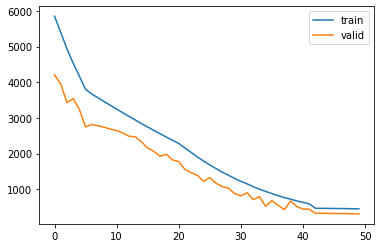

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_losses)
plt.plot(valid_losses)
plt.legend(['train','valid'])

In [ ]:
torch.save({'model_state_dict': enc.state_dict()},path/'final_enc.pt')
torch.save({'model_state_dict': dec.state_dict()},path/'final_dec.pt')

In [6]:
checkpoint = torch.load('/content/drive/MyDrive/auto/enc.pt')
enc.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [7]:
enc.cuda()

ConvEncoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
)

In [8]:
#function to take in an image and create an embedding using GPUs

def create_embedding(encoder, full_loader, embedding_dim):
    encoder.eval()
    embedding = torch.randn((1, 64, 64, 64))

    with torch.no_grad():
        for batch_idx, (train_img, target_img) in enumerate(full_loader):
            train_img = train_img.cuda()
            enc_output = encoder(train_img).cpu()
            embedding = torch.cat((embedding, enc_output), 0)
    
    return embedding

full_loader = full_loader = torch.utils.data.DataLoader(dataset, batch_size=16)

In [ ]:
#create embeddings for the entire dataset

embedding = create_embedding(enc, full_loader, embedding_dim)

In [ ]:
#save all encodings into a numpy serialized file

num = embedding.shape[0]
emb = numpy_embedding.reshape((num, -1))
np.save("data_embedding_f.npy",emb)

### Inference

In [ ]:
#three helper functions

def load_image(path):
    img= T.ToTensor()(Image.open(path))
    img = img.unsqueeze(0)
    return img

def find_images(path, num_images, embedding):
    img = load_image(path)
    img = img.cuda()

    with torch.no_grad():
        image_emb = encoder(img).cpu().detach().numpy()


    flat_emb = image_emb.reshape((image_emb.shape[0], -1))

    knn = NearestNeighbors(n_neighbors=num_images, metric="cosine")
    knn.fit(embedding)

    _, idxs = knn.kneighbors(flat_emb)
    idxs = idxs.tolist()
    return idxs

def show_images(idxs):
    idxs = idxs[0]
    for idx in idxs:
        img_name = str(idx - 1) + ".jpg"
        img_path = path/f'{img_name}'
        img = Image.open(img_path).convert("RGB")
        plt.imshow(img)
        plt.show()

In [ ]:
#inference engine 

def infer(path_to_enc,path_to_emb_file,test_img_path,num_of_images)

  encoder.load_state_dict(torch.load(path_to_enc, map_location='cuda'))
  encoder.eval()
  encoder.cuda()

  # Load the embedding file 
  embedding = np.load(path_to_emb_file)

  #get indexes of similar images
  idxs = find_images(test_img_path,num_of_images, embedding)
  
  #show them in a column 
  show_images(idxs)